In [1]:
from PIL import Image, ImageOps
import shutil
import os
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [127]:
import os
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

# Parameters
image_dir = '../data/train_features'
label_csv = '../data/train_labels.csv'
low_classes = ['bird', 'hog']
output_width = 300
output_height = 200
channels_number = 1  # 3 = RGB, 1 = black & white
use_padding = True  # Set this to False if you do not want to apply padding
batch_size = 32  # for model
epochs_number = 1 # for model

# Load the CSV file with labels
df = pd.read_csv(label_csv)

# Perform stratified split based on the labels
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[df.columns[1:]])

# Create a dictionary where the key is the file name, and the value is the list of labels
train_dict = {str(row['id']): row[1:].values.tolist() for _, row in train_df.iterrows()}
val_dict = {str(row['id']): row[1:].values.tolist() for _, row in val_df.iterrows()}

def create_classes_to_augment(df_csv, target_classes):
    # Calculate the average number of images across all classes
    class_counts = df_csv.drop(columns=['id'] + target_classes).sum(axis=0)
    avg_count = int(class_counts.mean())

    target_classes_dict = {}

    # Perform augmentation for each target class
    for target_class in target_classes:
        # Filter the dataframe for the target class
        class_df = df_csv[df_csv[target_class] == 1]
        # Calculate how many images need to be generated
        num_images_needed = avg_count - len(class_df)
        target_classes_dict[target_class] = num_images_needed

    return target_classes_dict

# Count number of augmentations for low classes only for training dataset
classes_to_augment = create_classes_to_augment(train_df, low_classes)

# Get the list of classes (all columns except 'id')
class_names = list(label_df.columns[1:])

# Function to load and decode images
def load_and_decode_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG image to RGB format
    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert image to float32 and normalize to [0, 1]
    return image

# Function to get labels
def get_label(file_name):
    # Get the label list from the appropriate dictionary based on the file_name
    label = train_dict.get(file_name.numpy().decode('utf-8'), None)  # Use the training dictionary by default

    if label is None:  # If label is not found in training, try validation dictionary
        label = val_dict.get(file_name.numpy().decode('utf-8'), None)
    
    label_tensor = tf.convert_to_tensor(label, dtype=tf.float32)  # Convert to a tensor
    return label_tensor

# Wrapper function to load image and get label
def load_image_and_label(file_path):
    file_name = tf.strings.regex_replace(tf.strings.split(file_path, '/')[-1], '.jpg', '')
    image = load_and_decode_image(file_path)
    
    # Use tf.py_function to get the label and ensure it has the correct shape
    label = tf.py_function(get_label, inp=[file_name], Tout=tf.float32)
    label.set_shape([len(class_names)])  # Set shape of the label tensor
    
    return image, label

# Create a tf.data.Dataset from image paths
image_paths = tf.data.Dataset.list_files(f"{image_dir}/*.jpg")

# Load images and labels for both train and validation datasets
train_dataset = image_paths.map(lambda x: load_image_and_label(x))
val_dataset = image_paths.map(lambda x: load_image_and_label(x))

#---------------------------------------------------------------------------------------------------------------------

# Define a function to check if the specified region is approximately white
def is_region_approximately_white(image, x_start=60, x_end=70, y_end=8, tolerance=30):
    # Convert image to float32 to perform numerical operations
    image = image*255.0
    #image = tf.cast(image, tf.float32)

    # Select the specified region from the image
    selected_region = image[-y_end:, x_start:x_end, :]  # Last 'y_end' rows and columns between 'x_start' and 'x_end'

    # Calculate the difference from pure white (255, 255, 255)
    white_diff = tf.abs(selected_region - 255)

    # Check if the maximum deviation from white is within the tolerance
    white_check = tf.reduce_all(white_diff <= tolerance)

    return white_check

# Define a function to conditionally crop the image
def conditional_crop_image(image, label, x_start=60, x_end=70, y_end=8, tolerance=30):
    # Check if the specified region is approximately white
    if is_region_approximately_white(image, x_start, x_end, y_end, tolerance):
        # Get the current shape of the image
        height, width, _ = tf.shape(image)[0], tf.shape(image)[1], tf.shape(image)[2]
        
        # Crop the image from the bottom by 15 pixels
        image = tf.image.crop_to_bounding_box(image, offset_height=0, offset_width=0, target_height=height-16, target_width=width)
    
    return image, label

# Apply the conditional cropping function to the dataset
train_dataset = train_dataset.map(lambda image, label: conditional_crop_image(image, label))
val_dataset = val_dataset.map(lambda image, label: conditional_crop_image(image, label))

#---------------------------------------------------------------------------------------------------------------------

def is_bright_orange(rgb):
    #r, g, b = tf.unstack(tf.cast(rgb, tf.int32))
    
    # Ensure the RGB input is a tensor of type int32
    rgb = tf.cast(rgb, tf.int32)
    

    # Extract the r, g, b channels by indexing
    r = rgb[..., 0]
    g = rgb[..., 1]
    b = rgb[..., 2]
    # Approximate boundaries for bright orange color in RGB
    return tf.logical_and(
        tf.logical_and(r > 180, tf.logical_and(g > 50, g < 200)),
        b < 110
    )

def replace_logo_with_neighboring_colors(image, search_area_height=50, search_area_width=50):
    # Convert the image to a tensor with float32 type
    #image = tf.cast(image, tf.float32)
    image = image*255.0

    # Get the image dimensions
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]

    # Initialize a list to store the coordinates of orange pixels
    orange_points = tf.TensorArray(tf.int32, size=0, dynamic_size=True)

    # Iterate over the bottom-left 50x50 rectangle
    for x in tf.range(search_area_width):
        for y in tf.range(height - search_area_height, height):
            # Check if the pixel is bright orange
            if is_bright_orange(image[y, x]):
                orange_points = orange_points.write(orange_points.size(), [x, y])

    # If orange pixels are found
    if orange_points.size() > 0:
        # Convert orange_points to a tensor
        orange_points = orange_points.stack()

        # Find the top-right orange point and adjust some points more
        max_orange_x = tf.reduce_max(orange_points[:, 0]) + 3
        min_orange_y = tf.reduce_min(orange_points[:, 1]) - 5

        # Iterate to replace the logo with vertical lines, using colors of the pixel above
        for x in tf.range(max_orange_x):
            # Get the color from the pixel above
            color = image[min_orange_y - 1, x]
            for y in tf.range(min_orange_y, height):
                image = tf.tensor_scatter_nd_update(image, [[y, x]], [color])
    image = image/255.0
    
    return image


# Function to apply to the dataset
def preprocess_image(image, label):
    image = replace_logo_with_neighboring_colors(image)

    return image, label

# Apply the conditional cropping function to the dataset
train_dataset = train_dataset.map(preprocess_image)
val_dataset = val_dataset.map(preprocess_image)

#---------------------------------------------------------------------------------------------------------------------

def find_max_dimensions(dataset):
    # Function to extract height and width
    def extract_dimensions(image, _):
        height = tf.shape(image)[0]
        width = tf.shape(image)[1]
        return height, width

    # Map the dataset to extract dimensions
    dimension_dataset = dataset.map(extract_dimensions)

    # Initialize max height and width tensors
    max_height = tf.constant(0)
    max_width = tf.constant(0)

    # Use reduce to find the maximum dimensions
    for height, width in dimension_dataset:
        max_height = tf.maximum(max_height, height)
        max_width = tf.maximum(max_width, width)
    
    return max_height.numpy(), max_width.numpy()


# Find the maximum dimensions of the training dataset
#max_height, max_width = find_max_dimensions(train_dataset)
max_height, max_width = 524, 960


# Define your padding function
def pad_images(image, max_width, max_height):
    # Get the current dimensions of the image
    current_height, current_width = tf.shape(image)[0], tf.shape(image)[1]

    # Calculate the padding required to center the image
    delta_width = max_width - current_width
    delta_height = max_height - current_height

    # Calculate padding for top/bottom and left/right
    padding_top = delta_height // 2
    padding_bottom = delta_height - padding_top
    padding_left = delta_width // 2
    padding_right = delta_width - padding_left

    # Apply padding using tf.pad
    image_padded = tf.pad(
        image,
        paddings=[[padding_top, padding_bottom], [padding_left, padding_right], [0, 0]],  # Padding for height, width, and channels
        mode='CONSTANT',  # Use constant padding
        constant_values=0  # Use 0 for black padding
    )
    return image_padded

# Apply padding to datasets only if use_padding is True
if use_padding:
    train_dataset = train_dataset.map(lambda image, label: (pad_images(image, max_width, max_height), label))
    val_dataset = val_dataset.map(lambda image, label: (pad_images(image, max_width, max_height), label))

# Continue with model training
# model.fit(train_dataset.batch(batch_size), epochs=epochs_number, validation_data=val_dataset.batch(batch_size))

#---------------------------------------------------------------------------------------------------------------------


def resize_image(image, output_height, output_width):
    image = tf.image.resize(image, [output_height, output_width])
    image.set_shape([output_height, output_width, 3])  # Set fixed shape for resized image
    return image

# Resize images using the separate function
train_dataset = train_dataset.map(lambda image, label: (resize_image(image, output_height, output_width), label))
val_dataset = val_dataset.map(lambda image, label: (resize_image(image, output_height, output_width), label))

def set_channel(image,channels_number):
    if channels_number == 3:
        return image
    else:
        # Convert RGB image to grayscale
        image = tf.image.rgb_to_grayscale(image)
        #image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]
    return image

# RGB or BLACK&WHITE channel
train_dataset = train_dataset.map(lambda image, label: (set_channel(image, channels_number), label))
val_dataset = val_dataset.map(lambda image, label: (set_channel(image, channels_number), label))



# Print dataset example
for img_batch, lbl_batch in val_dataset.take(3):
    print("Image batch shape:", img_batch.shape)
    print("Label batch shape:", lbl_batch.shape)

Image batch shape: (200, 300, 1)
Label batch shape: (8,)
Image batch shape: (200, 300, 1)
Label batch shape: (8,)
Image batch shape: (200, 300, 1)
Label batch shape: (8,)


Image shape: (200, 300, 1)
Label: [0. 0. 0. 1. 0. 0. 0. 0.]


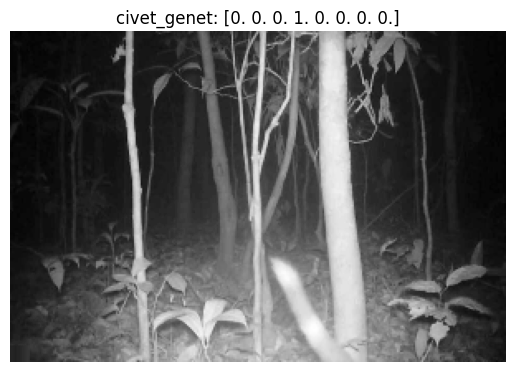

In [128]:
# Take one element from the dataset
for image, label in val_dataset.take(1):
    print("Image shape:", image.shape)
    print("Label:", label.numpy())  # Convert the label tensor to a numpy array for easier viewing

    # Find the index of the maximum value in the one-hot encoded label
    index = np.argmax(label)

    # Retrieve the corresponding class name
    animal_name = class_names[index]

  # Revert the normalization
    image = (image.numpy() * 255.0).astype("uint8")  # Scale back to [0, 255]

    #image = image.numpy().astype("uint8")
    plt.imshow(image, cmap='gray')
    plt.title(f"{animal_name}: {label}")
    plt.axis('off')